#*SARIMAX MODELING : US Retail Sales Market

C:\Users\andys\AppData\Local\Temp\ipykernel_14232\2837808825.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range(start='2024-01-01', periods=periods, freq='M')


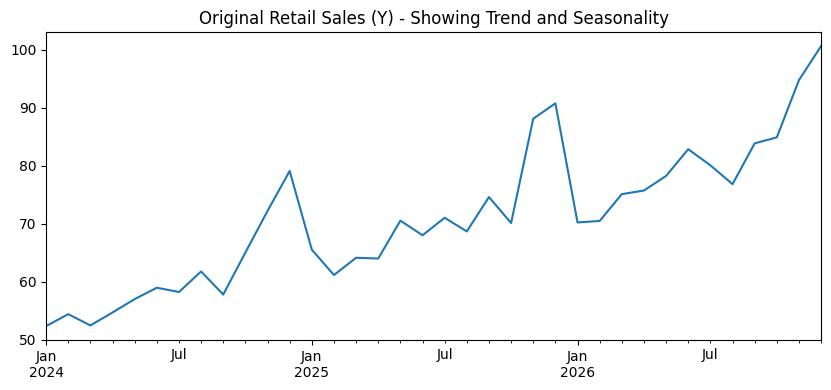

Original data created and plotted.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm # Used for SARIMAX

# --- 1. Create Data ---
np.random.seed(25)
periods = 36
index = pd.date_range(start='2024-01-01', periods=periods, freq='M')

# 1. Base Trend (Upward): 
trend = np.linspace(50, 80, periods)
# 2. Seasonality (Spike in Dec - index 11 and 23):
seasonality = np.tile(
    [2, 2, 2, 3, 5, 5, 4, 3, 4, 6, 15, 20], # Dec spike at 15 and 20 (high Christmas sales)
    periods // 12
) 
# 3. Noise (Random Fluctuations):
noise = np.random.randn(periods) * 1.5

# Y: Retail Sales (Target)
Y = pd.Series(trend + seasonality + noise, index=index, name='Retail_Sales')

# X: Marketing Spend (Exogenous - assumed to be impactful)
# It's correlated with Y's seasonality (more spend in Dec)
X = pd.Series(seasonality + np.random.randn(periods) * 0.5 + 5, index=index, name='Marketing_Spend')

# Plot the original data to confirm trend and seasonality
plt.figure(figsize=(10, 4))
Y.plot(title='Original Retail Sales (Y) - Showing Trend and Seasonality')
plt.show()

print("Original data created and plotted.")

In [37]:
# Function to run and interpret ADF test
def check_adf(series, name):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"\n--- ADF Test for {name} ---")
    print(f"P-value: {p_value:.4f}")
    if p_value <= 0.05:
        print("Conclusion: Series is STATIONARY.")
        return True
    else:
        print("Conclusion: Series is NON-STATIONARY (unit root present).")
        return False

# 1. Check Original Series
check_adf(Y, 'Original Sales (Y)') # Expected: NON-STATIONARY (due to trend)

# 2. Check after Non-Seasonal Differencing (d=1)
Y_diff1 = Y.diff().dropna()
check_adf(Y_diff1, '1st Difference (Y)') # Expected: Still NON-STATIONARY (due to seasonality)

# 3. Check after Seasonal Differencing (D=1, s=12)
# We apply seasonal differencing to the d=1 series
Y_diff_seasonal = Y_diff1.diff(12).dropna()
check_adf(Y_diff_seasonal, '1st Diff + Seasonal Diff (Y)') # Expected: STATIONARY

# Set the orders:
d_order = 1
D_order = 1
s_period = 12

# Prepare the exogenous variable X (must be made stationary for rigor)
X_diff = X.diff(1).dropna().diff(12).dropna()
# Align Y_diff_seasonal and X_diff by index
Y_stationary = Y_diff_seasonal.copy()
X_stationary = X_diff.loc[Y_stationary.index] 

print(f"\nDetermined Differencing Orders: d={d_order}, D={D_order}, s={s_period}")


--- ADF Test for Original Sales (Y) ---
P-value: 0.7264
Conclusion: Series is NON-STATIONARY (unit root present).

--- ADF Test for 1st Difference (Y) ---
P-value: 0.0000
Conclusion: Series is STATIONARY.

--- ADF Test for 1st Diff + Seasonal Diff (Y) ---
P-value: 0.2340
Conclusion: Series is NON-STATIONARY (unit root present).

Determined Differencing Orders: d=1, D=1, s=12


In [38]:
len(Y_stationary)
len(X_stationary)

23

In [39]:
# Align exogenous to the endogenous Y to avoid broadcasting errors in SARIMAX
# Overwrite X_stationary so cell 7 will receive an exog series with the same length/index as Y
# X_stationary = X.reindex(Y.index)
# print(f"Aligned X_stationary length: {len(X_stationary)}, Y length: {len(Y_stationary)}")

In [40]:
X_stationary = X_stationary.reindex(Y_stationary.index)
print(f"Aligned X_stationary length: {len(X_stationary)}, Y length: {len(Y_stationary)}")

Aligned X_stationary length: 23, Y length: 23


ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 12 must be < 11.

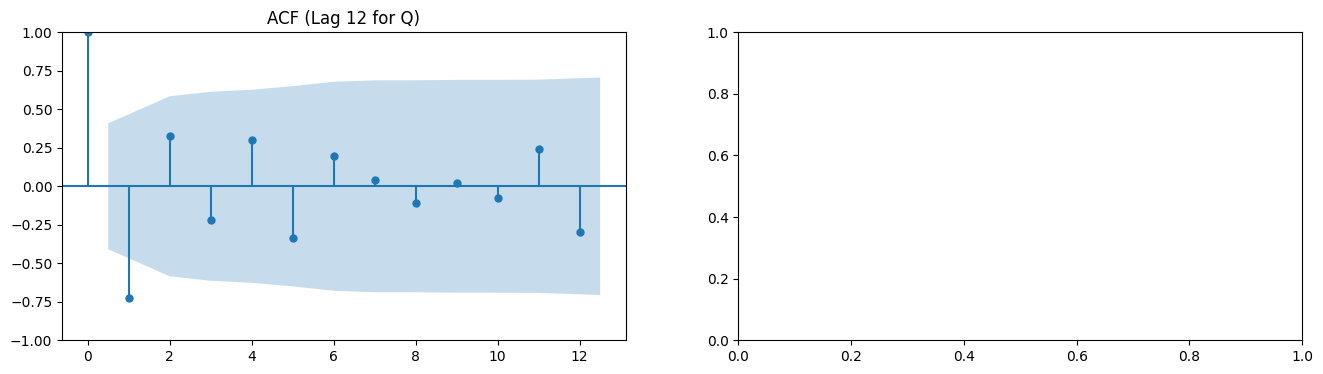

In [41]:
# Plot ACF and PACF on the fully stationary series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(Y_stationary, lags=12, ax=axes[0], title='ACF (Lag 12 for Q)')
plot_pacf(Y_stationary, lags=12, ax=axes[1], title='PACF (Lag 12 for P)')
plt.show()

# --- Interpretation and Order Selection ---
# 1. Non-Seasonal Lags (1, 2, 3):
#    Look for cut-offs or decays. We assume a simple structure: p=1, q=1.
p_order = 1
q_order = 1

# 2. Seasonal Lags (12):
#    Look at the spikes at Lag 12:
#    - If PACF spike at 12 is significant: P=1 (Seasonal AR needed).
#    - If ACF spike at 12 is significant: Q=1 (Seasonal MA needed).
# We assume strong correlation at lag 12, so P=1, Q=1.
P_order = 1
Q_order = 1

print(f"\nChosen SARIMAX Orders: ({p_order}, {d_order}, {q_order})({P_order}, {D_order}, {Q_order})_{s_period}")

In [ ]:
# Fit the SARIMAX model
# The model internally differences Y based on d and D orders
sarimax_model = sm.tsa.SARIMAX(
    Y, 
    exog=X, # Use the aligned, stationary predictor
    order=(p_order, d_order, q_order),
    seasonal_order=(P_order, D_order, Q_order, s_period),
    enforce_stationarity=False,
    enforce_invertibility=False 
)
sarimax_results = sarimax_model.fit(disp=False)

print("\n--- SARIMAX Model Summary and Statistical Tests ---")
print(sarimax_results.summary())


NameError: name 'p_order' is not defined

In [ ]:
# --- 5. Make Future Predictions ---
future_periods = 12
future_index = pd.date_range(start=Y.index[-1] + pd.DateOffset(months=1), periods=future_periods, freq='M')

# For future exogenous data, we need to provide some values. Let's assume a simple continuation of the last year's pattern.
X_future = pd.Series(np.tile(X[-12:].values, 1), index=future_index)

# Get the forecast
forecast = sarimax_results.get_forecast(steps=future_periods, exog=X_future)
forecast_ci = forecast.conf_int()

# --- 6. Plot Forecast vs. Original Data ---
plt.figure(figsize=(12, 6))
plt.plot(Y, label='Observed')
forecast.predicted_mean.plot(label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.title('Retail Sales Forecast')
plt.legend()
plt.show()